In [10]:
import numpy as np
import astropy.units as u
from pyirf import spectral,simulations,utils 
import math
#import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from IPython.display import display, Latex

### Muon rates

In [658]:
def muon_rate(muon_energy = 1*u.GeV):
    """
    Function to calculate rate of muons with energy 1GeV for 1 LST 

    still need to be implemented:
        - dependence on energy
        - dependence on a.s.l.
        - only muon rings fully contained in the mirror
    
    Parameters
    ----------
    lst_mirror_area : float 
        area of LST mirror in m^2 [Gaug 2019]
    lst_fov : float 
        lst field of view in sr^-1 [Gaug 2019]
    ----------
    Return
    
    rate of muons for the 1LST
    """
    # a.s.l. for 1 GeV muons [from PDG]
    rate_of_muons = 70 * u.m**(-2) * u.sr**(-1)* u.s**(-1)
    # at 600 a.s.l. 1.79 for muons > 25GeV (for muons > 16GeV the factor will be 3.55) [from Pascale et al. 1993]
    rate_of_muons = 1.79 * u.m**(-2) * u.sr**(-1)* u.s**(-1)
    lst_mirror_area = 378 * u.m**(2)
    lst_fov = utils.cone_solid_angle(4.3*u.deg)
    return rate_of_muons*lst_mirror_area*lst_fov

In [659]:
lst_mirror_area = 378 * u.m**(2)
lst_fov = utils.cone_solid_angle(4.3*u.deg)
print(muon_rate())

11.966923032585234 1 / s


In [113]:
# Equation number 75 from Gaug
def H(energy):
    y = math.log10(energy)
    H1 = 0.133
    H2 = -2.521
    H3 = -5.78
    S2 = -2.11
    return H1 * (0.5*(y**3) - 2.5*(y**2) + 3*y) \
           + H2 * (-2*(y**3)/3 + 3*(y**2) - (10*y)/3 + 1) \
           + H3 * ((y**3)/6 - (y**2)/2 + y/3) \
           + S2 * ((y**3)/3 - 2*(y**2) + 11*y/3 -2 )

def flux(energy):
    C = 0.86
    parameter_h = H(energy)
    return (C * 10**parameter_h)

In [146]:
result = quad(flux, 20, 1000)
result

(2.7120272352868615, 1.7463258375477594e-08)

In [325]:
(result[0] * lst_fov * lst_mirror_area * 0.7).to_value()

12.691751302160313

In [1]:
def rate_100(energy, theta = 0):
    """
    Equation (78) from Gaug et al. 2019
    """
    return 1.4e3 * energy**(-2.7) \
           * (1 / (1 + (1.1*energy*math.cos(np.deg2rad(theta))/(115))) \
           + (0.054 / (1 + (1.1*energy*math.cos(np.deg2rad(theta))/850))))


def max_rate(energy, theta = 0):
    """
    Equation (80) from Gaug et al. 2019
    """
    mirror_radius = 23
    impact_max = 0.8*mirror_radius
    impact_min = 0.2*mirror_radius
    #muon_angle_max = 4.5/2 - 0.2 
    muon_angle_max = 1.5
    return rate_100(energy) * math.cos(np.deg2rad(theta)) \
           * (impact_max**2 - impact_min**2) * 2 * math.pi**2 \
           * (1 - math.cos(np.deg2rad(muon_angle_max)))

In [433]:
max_r = quad(max_rate, 20, np.inf)
max_r[0]

6.386238225388449

In [418]:
max_r[0] * lst_fov.to_value() * lst_mirror_area.to_value()

56.926347345234795

In [326]:
80/6.9

11.594202898550725

### Time of simulation


In [437]:
def proton_rate(area, solid_angle, energy_integral):
    """
    Equation for all particle spectrum from PDG https://pdg.lbl.gov/2022/reviews/rpp2022-rev-cosmic-rays.pdf
    
    Parameters:
    -----------
    norm - normalisation factor [GeV^-1 sr^-1 s^-1 m^-2]
    energy_integral - result of integration of energy spectrum from Emin to Emax [GeV]
    solid_angle - solid angle of FoV [sr]
    area - area for integration [m^2]
    -----------
    Returns:
    -----------
    rate of protons for a given area and solid angle with given energy spectrum [s^-1]
    """
    norm = 1.8e4
    proton_fraction = 0.74
    return norm * area * solid_angle * proton_fraction * energy_integral

In [149]:
Nshow = 20e4 * 10 * 500
E_min = 10
E_max = 103901
viewcone = 9
side = 1511.53
area = side**2
solid_angle = utils.cone_solid_angle(viewcone*u.deg).to_value()

# E^-2.7 from 10 to 10e5 GeV
energy_integral_true_spec = 0.01173 
# E^-2.7 from 10 to 103901 GeV
energy_integral_true_spec = 0.01172

# E^-0.7 from 10 to 10e5 GeV
energy_integral_weigthed_spec = 98.75 
# E^-0.7 from 10 to 103901 GeV
energy_integral_weigthed_spec = 99.97 

energy_integral_true_spec = 0.1

In [167]:
power_law_spectrum = spectral.PowerLaw(normalization=1.8e1 * spectral.DIFFUSE_FLUX_UNIT, index = -2, e_ref = 1 * u.GeV)

In [168]:
power_law_spectrum

PowerLaw(18.0 1 / (TeV s sr m2) * (E / 1.0 GeV)**-2)

In [263]:
quantity_in_tev = 1 * u.Unit("u.TeV**-1")
quantity_in_gev = quantity_in_tev.to("u.GeV**-1")
quantity_in_gev

<Quantity 0.001 u / GeV>

In [221]:
simulated_events

SimulatedEventsInfo(n_showers=1000000000, energy_min=10.000 GeV, energy_max=103.90 TeV, spectral_index=-2.0, max_impact=1.51 km, viewcone=9.0 deg)

In [999]:
simulated_events = simulations.SimulatedEventsInfo(n_showers = int(42091), 
                                                   energy_min=10*u.GeV, 
                                                   energy_max=103.9*u.TeV, 
                                                   max_impact = 1.511*u.km, 
                                                   spectral_index=-2, 
                                                   viewcone=9*u.deg)

powerlaw_test = spectral.PowerLaw.from_simulation(simulated_events, obstime=60*u.s, e_ref = 1 * u.GeV)
(powerlaw_test.normalization.to_value() / 1000) * u.Unit("GeV**-1 * sr**-1 * s**-1 * m**-2")

<Quantity 12796.53761536 1 / (GeV s sr m2)>

In [1017]:
simulated_events = simulations.SimulatedEventsInfo(n_showers = int(2e5 * 499), 
                                                   energy_min=10*u.GeV, 
                                                   energy_max=103.9*u.TeV, 
                                                   max_impact = 1.511*u.km, 
                                                   spectral_index=-2, 
                                                   viewcone=9*u.deg)

powerlaw_test = spectral.PowerLaw.from_simulation(simulated_events, obstime=0.1*u.s, e_ref = 1 * u.GeV)

(powerlaw_test.normalization.to_value() / 1000) * u.Unit("GeV**-1 * sr**-1 * s**-1 * m**-2")

<Quantity 17988.58821899 1 / (GeV s sr m2)>

In [810]:
simulated_events = simulations.SimulatedEventsInfo(n_showers = int(2e4*10*499), 
                                                   energy_min=10*u.GeV, 
                                                   energy_max=103.9*u.TeV, 
                                                   max_impact = 1.511*u.km, 
                                                   spectral_index=-2.7, 
                                                   viewcone=9*u.deg)
powerlaw_test = spectral.PowerLaw.from_simulation(simulated_events, obstime=0.0011*u.s, e_ref = 1 * u.GeV)
powerlaw_test.normalization.to("GeV**-1 s**-1 sr**-1 m**-2")

<Quantity 16193.43669144 1 / (GeV s sr m2)>

In [777]:
42000/1.38

30434.782608695656

In [998]:
side = 1511
unit = spectral.DIFFUSE_FLUX_UNIT
e_max = 103900
e_min = 10
index = -2.7
e_ref = 1
n_showers = 2e4 * 5e2 * 10
obstime = 0.85
A = np.pi*side**2
viewcone = 9

solid_angle = utils.cone_solid_angle(viewcone*u.deg).to_value()
delta = e_max ** (index + 1) - e_min ** (index + 1)
nom = (index + 1) * e_ref**index * n_showers
denom = A * obstime * solid_angle * delta

normalisation = (nom / denom)
normalisation

18065.700162862482

In [581]:
obs_time = nom / (normalisation * solid_angle * delta * A) 
obs_time

0.6931989999999999

In [506]:
solid_angle = utils.cone_solid_angle(viewcone*u.deg).to_value()
solid_angle
viewcone*u.deg

<Quantity 9. deg>

### Function for observational time

### Check Workflow

1. Take good simtel simulation for 1LST in which I am sure.
2. Process it and calculate number of protons and muons.
3. Check corsika parameters of this simulation.
4. Calculate obs time of these events.


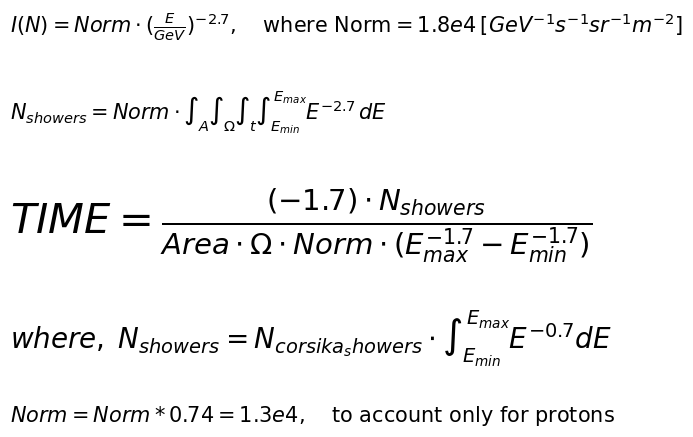

In [997]:
proton_norm_text = r'Norm = Norm * 0.74 = 1.3e4, \: \: \: \: \: \text{to account only for protons}'
intensity_text = r'I(N) = Norm \cdot (\frac{E}{GeV})^{-2.7}, \: \: \: \: \: \text{where Norm} = 1.8e4 \: [GeV^{-1} s^{-1} sr^{-1} m^{-2} ]'
shower_number_text = r'N_{showers} = Norm \cdot \int_A \int_{\Omega} \int_{t} \int_{E_{min}}^{E_{max}} E^{-2.7} \,dE'
time_text = r'TIME = \frac{(-1.7)\cdot N_{showers}}{Area \cdot \Omega \cdot Norm \cdot (E_{max}^{-1.7} - E_{min}^{-1.7})}'
n_showers_text = r'where, \; N_{showers} = N_{corsika_showers} \cdot \int_{E_{min}}^{E_{max}} {E^{-0.7} dE} '
ax = plt.axes([0,0,0.3,0.3]) #left,bottom,width,height
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

_ = plt.text(0,2.2,'$%s$' %intensity_text,size=15,color="black")

_ = plt.text(0,1.6,'$%s$' %shower_number_text,size=15,color="black")

_ = plt.text(0,0.8,'$%s$' %time_text,size=30,color="black")

_ = plt.text(0,0,'$%s$' %n_showers_text,size=20,color="black")

_ = plt.text(0,-0.5,'$%s$' %proton_norm_text,size=15,color="black")





In [995]:
def observational_time(simulated_event_info, norm=18000):
    """
    Calculate observation time for simulated events
    
    Parameters
    ----------
    Parameters are taken from pyirf.simulations.SimulatedEventsInfo object

    e_min - min energy [GeV]
    e_max - max energy [GeV]
    index - index of simulated power law
    n_showers - number of simulated shower (reused accounted)
    viewcone - viewcone of simulation
    max_impact - diameter of the area for simulation
    e_ref - reference energy value
    norm - normalisation factor from all particles spectrum from PDG (normalised only for protons)
    ----------

    Returns
    ----------
    time of observation in seconds

    """

    e_min = simulated_event_info.energy_min.to("GeV")
    e_max = simulated_event_info.energy_max.to("GeV")
    index = simulated_event_info.spectral_index
    n_showers = simulated_event_info.n_showers
    viewcone = simulated_event_info.viewcone.to_value()
    max_impact = simulated_event_info.max_impact.to("m")
    e_ref = 1 * u.GeV
    norm = 0.74 * norm
    
    solid_angle = utils.cone_solid_angle(viewcone*u.deg).to_value()
    A = (np.pi * (max_impact**2))
    delta = e_max ** (index + 1) - e_min ** (index + 1)
    nom = (index + 1) * e_ref**index * n_showers
    denom = A * solid_angle * delta * norm

    return (nom / denom).to_value()


def observational_time_test(simulated_event_info, norm=18000):
    """Func for testing"""
    e_min = simulated_event_info.energy_min.to("GeV")
    e_max = simulated_event_info.energy_max.to("GeV")
    index = simulated_event_info.spectral_index
    n_showers = simulated_event_info.n_showers
    viewcone = simulated_event_info.viewcone.to("deg")
    max_impact = simulated_event_info.max_impact.to("m")
    e_ref = 1 # GeV

    norm = 0.74 * norm # account for protons in all particle spectrum
    solid_angle = utils.cone_solid_angle(viewcone)
    
    A = (np.pi * (max_impact**2))
    delta = e_max ** (index + 1) - e_min ** (index + 1)
    nom = (index + 1) * e_ref**index * n_showers
    denom = A * solid_angle * delta * norm

    print(f"e_min {e_min}")
    print(f"e_max {e_max}")
    print(f"index {index}")
    print(f"n_showers {n_showers}")
    print(f"viewcone {viewcone}")
    print("solid angle ", solid_angle)
    print(f"A = {A}")
    print(f"max_impact = {max_impact}")

    return (nom / denom).to_value()

#simulated_events = simulations.SimulatedEventsInfo(n_showers = int(2e4 * 1e1 * 500), energy_min=10*u.GeV, energy_max=103.9*u.TeV, max_impact = 1.511*u.km, spectral_index=-2, viewcone=9*u.deg)

#observational_time(simulated_events)



In [993]:
# MONO Simulation
path = '/fefs/aswg/data/mc/DL0/LSTProd2/TestDataset/Protons/Corsika/node_corsika_theta_10.0_az_248.117_/output'
runs = 499
scale_integral = 99.97
mono_shower_number = 2e4 * 10 * runs * scale_integral

weighted_proton_number = 114868
weighted_muon_number = 206

simulated_events2 = simulations.SimulatedEventsInfo(n_showers = int(mono_shower_number), 
                                                    energy_min=10*u.GeV, 
                                                    energy_max=103.9*u.TeV, 
                                                    max_impact = 1.511*u.km, 
                                                    spectral_index=-2.7, 
                                                    viewcone=9*u.deg)

time_mono = observational_time(simulated_events2)
print(f"time of observation for 500 runs of mono events = {time_mono} seconds")
print(f"Rate of protons = {weighted_proton_number/time_mono} Hz")
print(f"Rate of muons = {weighted_muon_number/time_mono} Hz")

time of observation for 500 runs of mono events = 115.01903834926273 seconds
Rate of protons = 998.6868404445871 Hz
Rate of muons = 1.7910078449314426 Hz


In [994]:
path = '/fefs/aswg/workspace/MC_common/corsika7.7_simtelarray_20200629/prod5/4LSTs_MAGIC/proton/zenith_20deg/south_pointing/corsika'
n_runs = 499
scale_integral = 98.75
stereo_shower_number = 1e6 * runs * scale_integral

weighted_proton_number = 328637
weighted_muon_number = 391
weighted_clean_muon_number = 1739

simulated_events3 = simulations.SimulatedEventsInfo(n_showers = int(stereo_shower_number), 
                                                    energy_min=10*u.GeV, 
                                                    energy_max=100*u.TeV, 
                                                    max_impact = 1.500*u.km, 
                                                    spectral_index=-2.7, 
                                                    viewcone=10*u.deg)

time_stereo = observational_time(simulated_events3)
print(f"time of observation for 500 runs of stereo events =  {time_stereo} seconds")
print(f"Rate of protons = {weighted_proton_number/time_stereo} Hz")
print(f"Rate of muons = {weighted_muon_number/time_stereo} Hz")
print(f"Rate of muons = {weighted_clean_muon_number/time_stereo} Hz")

time of observation for 500 runs of stereo events =  467.1411696481316 seconds
Rate of protons = 703.506822675342 Hz
Rate of muons = 0.8370060816830082 Hz
Rate of muons = 3.7226434169993636 Hz


In [884]:
simulated_events4 = simulations.SimulatedEventsInfo(n_showers = int(30000 * 10 * 499 * 98.7), energy_min=99*u.GeV, energy_max=200*u.TeV, max_impact = 2.372*u.km, spectral_index=-2.7, viewcone=5.057*u.deg)

print(f"time of observation for 500 runs of mono events =  {observational_time(simulated_events4)} seconds")

e_min 99.0 GeV
e_max 200000.0 GeV
index -2.7
n_showers 14775390000
viewcone 5.057 deg
solid angle  0.024457303069526867 sr
A = 17675806.640675154 m2
max_impact = 2372.0 m
time of observation for 500 runs of mono events =  10771.513170884638 seconds


e_min 10.0 GeV
e_max 103900.0 GeV
index -2
n_showers 100000000
viewcone 9.0 deg
solid angle  0.07735643747962972 sr
A = 7172636.160856582 m2
max_impact = 1511.0 m


0.13532010130614358

In [497]:
print(simulated_events2)

SimulatedEventsInfo(n_showers=5000000000, energy_min=10.000 GeV, energy_max=103.90 TeV, spectral_index=-2.0, max_impact=1.51 km, viewcone=9.0 deg)


In [748]:
utils.cone_solid_angle(np.deg2rad(90))

<Quantity 6.28318531 sr>

In [750]:
utils.cone_solid_angle(np.deg2rad(180))

<Quantity 12.56637061 sr>

### Different tests


#### Energy reweighting

In [688]:
with open('/Users/vdk/energy.txt', 'r') as fi:
    one_line = fi.read()
    many_lines = one_line.split(",")
    energy_array_protons = [float(value) for value in many_lines[:-1]]

with open('/Users/vdk/energy_muons.txt', 'r') as fi:
    one_line = fi.read()
    many_lines = one_line.split(",")
    energy_array_muons = [float(value) for value in many_lines[:-1]]

w_protons = sum([energy**(-0.7) for energy in energy_array_protons])
w_muons = sum([energy**(-0.7) for energy in energy_array_muons])
print(f"protons = {w_protons}")
print(f"muons = {w_muons}")


protons = 114868.88719007111
muons = 206.1955031290796


In [697]:
with open('/Users/vdk/energy.txt', 'r') as fi:
    one_line = fi.read()
    many_lines = one_line.split(",")
    energy_array_protons = [float(value) for value in many_lines[:-1]]

with open('/Users/vdk/energy_muons.txt', 'r') as fi:
    one_line = fi.read()
    many_lines = one_line.split(",")
    energy_array_muons = [float(value) for value in many_lines[:-1]]

w_protons = sum([energy**(-0.7) for energy in energy_array_protons])
w_muons = sum([energy**(-0.7) for energy in energy_array_muons])
print(f"protons = {w_protons}")
print(f"muons = {w_muons}")
simulated_spectrum = spectral.PowerLaw(normalization = 1 * spectral.DIFFUSE_FLUX_UNIT, index = -2, e_ref =1* u.TeV)
target_spectrum = spectral.PowerLaw(normalization = 1 * spectral.DIFFUSE_FLUX_UNIT, index = -2.7, e_ref =1* u.TeV)
pyirf_weighted = [spectral.calculate_event_weights(energy*u.TeV, target_spectrum=target_spectrum, simulated_spectrum=simulated_spectrum) for energy in energy_array_protons]

In [699]:
sum(pyirf_weighted)

114868.88719007115

In [700]:
206/114868

0.0017933628164501863

In [701]:
75/41972

0.001786905556085009

In [828]:
114868.88719007115 / 113

1016.5388246908951

In [829]:
202/113

1.7876106194690264

In [830]:
800/151000

0.005298013245033113

In [831]:
0.00529*328637

1738.4897300000002

In [837]:
328637.31717848254/466.9046424736262

703.8638884320926

In [839]:
1738/466

3.7296137339055795

In [846]:
29181311-29180848

463

In [875]:
def test_time():
    #Nprotons =  20000 * 10 * 499 
    Nprotons =  100000 * 10 * 499 * 99.7
    index = -2.7
    norm = 1.3e4
    max_impact = 1500
    area = np.pi*(max_impact**2)
    viewcone = 9
    solid_angle = utils.cone_solid_angle(np.deg2rad(viewcone)).to_value()
    Emax = 100000
    Emin = 10
    return (Nprotons * (index+1))/(1.3e4*area*solid_angle*(Emax**(index+1) - Emin**(index+1)))

In [876]:
300000 / test_time()

503.0935675042659

In [16]:
max_impact = 150
area = np.pi*(max_impact**2)
Nsim = 1000000
Nrec = 400
viewcone = 3.5
solid_angle = utils.cone_solid_angle(np.deg2rad(viewcone)).to_value()
flux = 13


rate = flux * solid_angle * area * (Nrec/Nsim)
rate

4.307659598843889